# AOS DM-45359 : focus sweep plots 

Simulation: `/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9` 

Could we run direct detect on the defocal  images, but cutouts on the in-focus ones,   to also have technically donut stamps?  

Load the defocal images; run direct detection:

In [6]:
from lsst.daf import butler as dafButler
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo_1e9')

collection = 'run1'
instrument= 'LSSTComCam'
detector=1
exposure_number = 5025082000942

# construct a dataId  for postISR extra-focal 
data_id_extra = {
    "detector": detector,
    "instrument": instrument,
    "exposure": exposure_number,
}
data_id_focus = { "detector": detector, "instrument": instrument, "exposure": exposure_number-1}
data_id_intra = { "detector": detector, "instrument": instrument, "exposure": exposure_number-2}
# read the postISR exposure

butler = dafButler.Butler(butlerRootPath)

exposure_extra = butler.get("postISRCCD", data_id_extra, collections=[collection])
exposure_focus = butler.get("postISRCCD", data_id_focus, collections=[collection])
exposure_intra = butler.get("postISRCCD", data_id_intra, collections=[collection])

Run direct detection:

In [10]:
from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig

from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import  ( 
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig)

from copy import copy 

config = GenerateDonutDirectDetectTaskConfig()

camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections=["LSSTComCam/calib/unbounded",],
)

exposure = copy(exposure_extra) # crucial step!!!! 
taskDirect = GenerateDonutDirectDetectTask(config=config)
catDirect = taskDirect.run(exposure, camera)
donutCatalog = catDirect.donutCatalog

cutoutTaskConfig = CutOutDonutsScienceSensorTaskConfig()
cutoutTask = CutOutDonutsScienceSensorTask(config=cutoutTaskConfig)


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 63 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 63 of 63 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 14/63 references


In [11]:
taskOutput = cutoutTask.run([copy(exposure_extra), copy(exposure_intra)],
    [donutCatalog, donutCatalog],
    camera,)

In [14]:
len(taskOutput.donutStampsExtra)

14

In [15]:
len(taskOutput.donutStampsIntra)

14

Ok, so the only issue is that the cutout code assumes we're doing intra/extra ... Cut we use cutout code to run in-focus cutouts? 

Right now the code assumes the same dataId,  distinguishing them by data type... So that would not be immediately useful. 

Even the actual `cutOutDonutsBase`  needs `DefocalType` since it builds a template and runs cross-correlation to re-center donuts ... 

    donutStampsFocus = cutoutTask.cutOutStamps(
            exposure_focus,
            donutCatalog,
            DefocalType.Extra,
            cameraName,
        )

So we'd need something like just characterize image, and cutout without all these templates...     

These come from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/generateDonutDirectDetectTask.py : 

In [1]:
from copy import copy

import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
import numpy as np
from lsst.meas.base import MeasurementError
from lsst.pipe.tasks.quickFrameMeasurement import (
    QuickFrameMeasurementTask,
    QuickFrameMeasurementTaskConfig,
)
from scipy.signal import correlate

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [ ]:
# # Run the measurement task
# objData = self.measurementTask.run(
#     exposure,
#     template,
#     donutDiameter=np.ceil(instrument.donutDiameter).astype(int),
#     cutoutPadding=self.config.initialCutoutPadding,
# )
# donutDf = pd.DataFrame.from_dict(objData.detectedCatalog, orient="index")
# # Use the aperture flux with a 70 pixel aperture
# donutDf[f"{bandLabel}_flux"] = donutDf["apFlux70"]

## Get in-focus exposure, run direct detection without pre-convolution

In [1]:
from lsst.daf import butler as dafButler
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo_1e9')

collection = 'run1'
instrument= 'LSSTComCam'
detector=1
exposure_number = 5025082000942

# construct a dataId  for postISR extra-focal 
data_id_extra = {
    "detector": detector,
    "instrument": instrument,
    "exposure": exposure_number,
}
data_id_focus = { "detector": detector, "instrument": instrument, "exposure": exposure_number-1}
data_id_intra = { "detector": detector, "instrument": instrument, "exposure": exposure_number-2}
# read the postISR exposure

butler = dafButler.Butler(butlerRootPath)

#exposure_extra = butler.get("postISRCCD", data_id_extra, collections=[collection])
exposure_focus = butler.get("postISRCCD", data_id_focus, collections=[collection])
#exposure_intra = butler.get("postISRCCD", data_id_intra, collections=[collection])

In [2]:
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTaskConfig,
GenerateDonutDirectDetectTask)

config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.doPreConvolution = False

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
from copy import copy
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections=["LSSTComCam/calib/unbounded",],
)
taskDirect = GenerateDonutDirectDetectTask(config=config)
catDirect = taskDirect.run(copy(exposure_focus), camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 390 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 390 of 390 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 10/390 references


In [6]:
srcCat = catDirect.donutCatalog

In [11]:
#

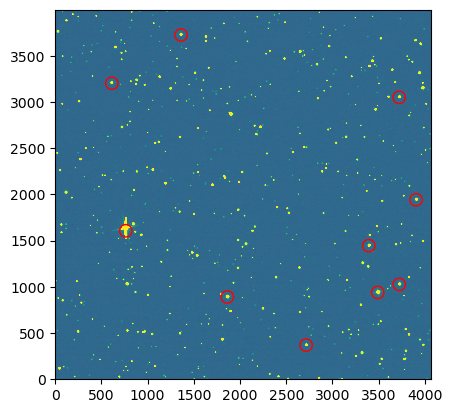

In [41]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

d = exposure_focus.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d,origin='lower', vmin=vmin, vmax=vmax)
plt.scatter(srcCat['centroid_x'], srcCat['centroid_y'],s=80, facecolors='none', edgecolors='r')

Try cutting out by hand to see if  the image is well centered or not ... 

In [30]:
x

762.8288031427148

Text(0.5, 0.98, 'star stamps before convolution')

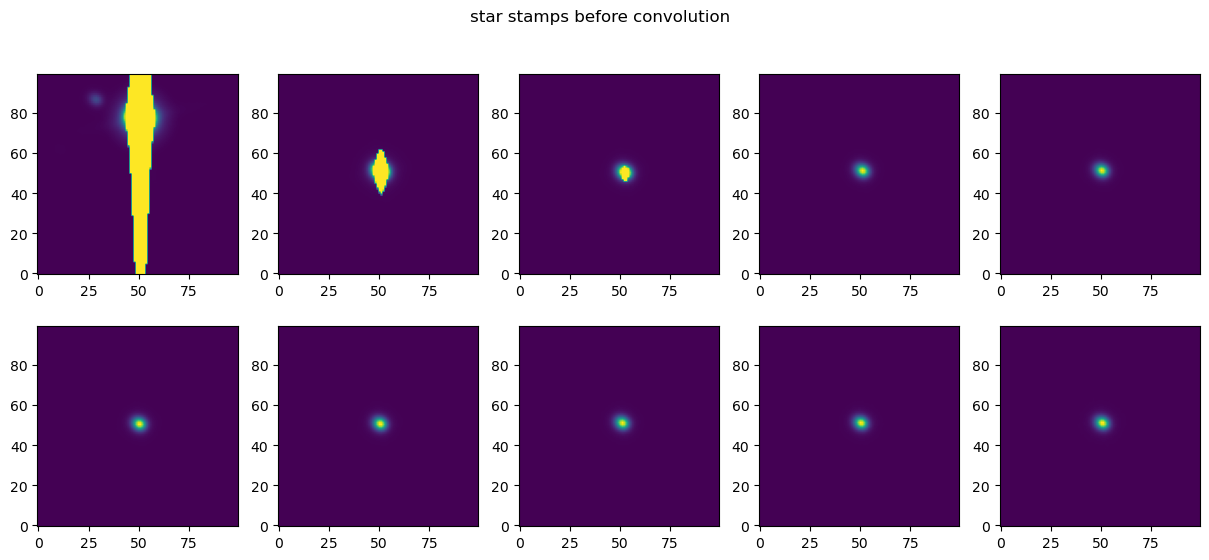

In [43]:
import numpy as np 
fix, axs = plt.subplots(2,5, figsize=(15,6))
ax  = np.ravel(axs)
w = 50
for i in range(len(srcCat)):
    y = int(srcCat['centroid_x'][i])
    x = int(srcCat['centroid_y'][i])
    ax[i].imshow(d[x-w:x+w, y-w:y+w],  
                 origin='lower')
    i+=1
fix.suptitle('star stamps before convolution')

We see that for the saturated source,  the position is not well-centered. 

ok, so indeed the brightest stars got selected! Now the only thing is to cutout postage stamps at these locations... 

In [140]:
from lsst.ts.wep.task.cutOutDonutsBase import (
    CutOutDonutsBaseTask,
    CutOutDonutsBaseTaskConfig,
    CutOutDonutsBaseTaskConnections,
)
from lsst.ts.wep.task.donutStamps import DonutStamps
from lsst.ts.wep.utils import DefocalType
from lsst.utils.timer import timeMethod

In [141]:
config = CutOutDonutsBaseTaskConfig()
task = CutOutDonutsBaseTask(config=config, name="Base Task")

In [142]:
cameraName = camera.getName()
exposures = [exposure_focus]
sourceCatalog = [srcCat]
starStamps = task.cutOutStamps(
            exposure_focus,
            srcCat,
            DefocalType.Focus,
            cameraName,
        )


In [143]:
len(
    starStamps
)

10

In [144]:
starStamps[0].stamp_im.image.array

array([[ 3.78410339e+00,  1.08627625e+01,  2.78520203e+01, ...,
         1.93168030e+01,  1.79008179e+01, -1.32469635e+01],
       [ 2.03657532e+00,  1.47784271e+01,  3.17676849e+01, ...,
         1.99548340e+00, -2.34891052e+01,  2.18163300e+01],
       [ 2.65781250e+01,  2.37461853e+01,  3.64880219e+01, ...,
         2.79528351e+01, -6.02651978e+00,  1.94576874e+01],
       ...,
       [ 8.19763184e+00,  4.64239044e+01, -1.02084351e+01, ...,
         5.16430725e+02,  8.66133240e+02,  1.35316821e+03],
       [ 2.53465271e+00,  1.95239105e+01, -1.72872009e+01, ...,
         3.21050537e+02,  6.01378784e+02,  8.95865112e+02],
       [-1.48086700e+01,  7.64785767e-01, -2.06713867e+00, ...,
         3.12202087e+02,  4.12723694e+02,  6.46330566e+02]], dtype=float32)

In [145]:
starStamps

In [146]:
maskedImage = starStamps[1].stamp_im

In [147]:
bit = maskedImage.mask.getPlaneBitMask(('SAT','BAD', 'NO_DATA'))
countAffectedPixels = len(np.where(np.bitwise_and(maskedImage.mask.array, bit))[0])


158

Text(0.5, 0.98, 'star stamps after pre-convolution')

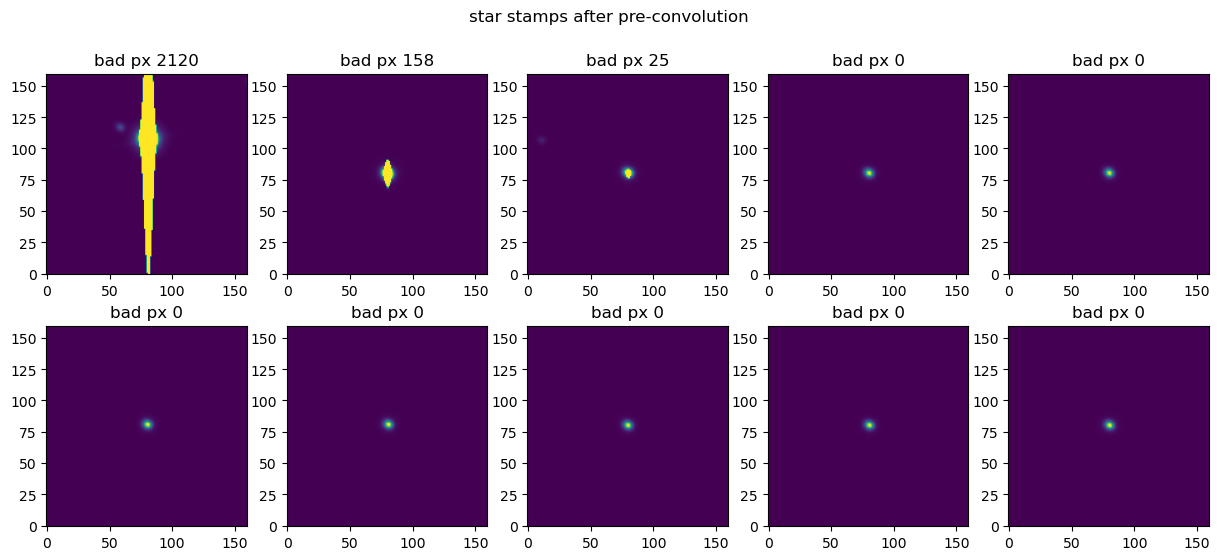

In [148]:
import numpy as np 
fix, axs = plt.subplots(2,5, figsize=(15,6))
ax  = np.ravel(axs)
i=0
for stamp in starStamps:
    maskedImage = stamp.stamp_im
    bit = maskedImage.mask.getPlaneBitMask(('SAT','BAD', 'NO_DATA'))
    countAffectedPixels = len(np.where(np.bitwise_and(maskedImage.mask.array, bit))[0])
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
    ax[i].set_title(f'bad px {countAffectedPixels}')
    i+=1

fix.suptitle('star stamps after pre-convolution')

so the saturated source still is not centered.  Let's ask Josh if that is even needed (or useful)....

In [29]:
from lsst.geom import Point2D, degrees
import lsst.afw.cameraGeom

donutStampSize = 160
initialCutoutPadding = 5

cutoutStamps = []

def shiftCenter(center, boundary, distance):
    """Shift the center if its distance to boundary is less than required.

    Parameters
    ----------
    center : float
        Center point.
    boundary : float
        Boundary point.
    distance : float
        Required distance.

    Returns
    -------
    float
        Shifted center.
    """

    # Distance between the center and boundary
    delta = boundary - center

    # Shift the center if needed
    if abs(delta) < distance:
        return boundary - np.sign(delta) * distance
    else:
        return center

exposure =  copy(exposure_focus)
#for donutRow in catDirect.donutCatalog.to_records():
donutRow =      catDirect.donutCatalog.to_records()[1]
# part of cutOutDonutsBase.calculateFinalCentroid
# https://github.com/lsst-ts/ts_wep/blob/1eccafaaacf8aa0358d7be37fbf2fdb8ff1fd3ba/python/lsst/ts/wep/task/cutOutDonutsBase.py#L268 
# Define corner for final stamp BBox
xCent = int(donutRow["centroid_x"])
yCent = int(donutRow["centroid_y"])



expDim = exposure.getDimensions()
initialCutoutSize = donutStampSize + (2 * initialCutoutPadding)
initialHalfWidth = int(initialCutoutSize / 2)
stampHalfWidth = int(donutStampSize / 2)

# Shift stamp center if necessary (if too close to the edge)
xCent = shiftCenter(xCent, expDim.getX(), initialHalfWidth)
xCent = shiftCenter(xCent, 0, initialHalfWidth)
yCent = shiftCenter(yCent, expDim.getY(), initialHalfWidth)
yCent = shiftCenter(yCent, 0, initialHalfWidth)

# Stamp BBox defined by corner pixel and extent
initXCorner = xCent - initialHalfWidth
initYCorner = yCent - initialHalfWidth

# Define BBox and get cutout from exposure
initCornerPoint = lsst.geom.Point2I(initXCorner, initYCorner)
initBBox = lsst.geom.Box2I(
    initCornerPoint, lsst.geom.Extent2I(initialCutoutSize)
)
initialCutout = exposure[initBBox]



d =initialCutout.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d,vmin=500,vmax=1600, origin='lower')



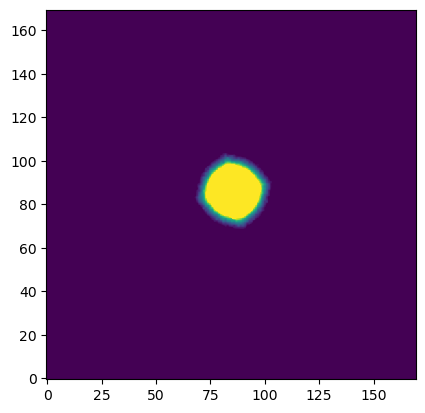

In [37]:
d =initialCutout.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d,vmin=500,vmax=1600, origin='lower')

If we convolve this with a donut stamp, it won't necessarily look well:

Something like `cutOutDonutsScienceSensor`, except that  it would be cutting the `in-focus` stars:


eg. `cutOutStarsScienceSensor`. Then it could inherit `cutOutDonutsBase`,  if I could add `DefocalType.Focus`  for in-focus exposure, then it would create the right template... 



In [38]:
from lsst.ts.wep.utils import DefocalType
from lsst.ts.wep.utils import (
    createTemplateForDetector,
    getOffsetFromExposure,
    getTaskInstrument,
)


In [39]:
getOffsetFromExposure?

Signature:
getOffsetFromExposure(
    exposure: lsst.afw.image._exposure._exposureContinued.Exposure,
    camName: str,
    defocalType: Union[lsst.ts.wep.utils.enumUtils.DefocalType, str],
) -> float
Docstring:
Get the offset from the exposure.

For LSSTCam and ComCam this corresponds to the offset of the detector
where the donut was imaged, while for AuxTel it corresponds to the offset
of M2.

Parameters
----------
exposure : lsst.afw.image.Exposure
    The exposure
camName : str
    Name of instrument using butler convention. Available instruments
    are LSSTCam, LSSTComCam, LSSTComCamSim, and LATISS.
defocalType : DefocalType, str, or None
    The DefocalType enum, or corresponding string.

Returns
-------
float
    The offset in mm

Raises
------
ValueError
    If the detector/camera combo is not supported
File:      /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/python/lsst/ts/wep/utils/taskUtils.py
Type:      function

In [41]:
#getTaskInstrument?


In [42]:
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import  ( 
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig)


In [47]:
config = CutOutDonutsScienceSensorTaskConfig()
task = CutOutDonutsScienceSensorTask(config=config)

In [48]:
task.config.instConfigFile

In [50]:

instConfigFile = None



detector = exposure.getDetector()
detectorName = detector.getName()
bandLabel = exposure.filter.bandLabel
defocalType=DefocalType.Extra


# In cutOutDonutsScienceSensorTask.py 
cameraName = camera.getName()

# instead of using this, we could set offset to 0 
offset = getOffsetFromExposure(exposure, cameraName, defocalType)


In [53]:

instrument = getTaskInstrument(
        cameraName,
        detectorName,
        offset,
        instConfigFile,
    )

In [85]:
DefocalType?

Init signature:
DefocalType(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
    boundary=None,
)
Docstring:     
Create a collection of name/value pairs.

Example enumeration:

>>> class Color(Enum):
...     RED = 1
...     BLUE = 2
...     GREEN = 3

Access them by:

- attribute access::

>>> Color.RED
<Color.RED: 1>

- value lookup:

>>> Color(1)
<Color.RED: 1>

- name lookup:

>>> Color['RED']
<Color.RED: 1>

Enumerations can be iterated over, and know how many members they have:

>>> len(Color)
3

>>> list(Color)
[<Color.RED: 1>, <Color.BLUE: 2>, <Color.GREEN: 3>]

Methods can be added to enumerations, and members can have their own
attributes -- see the documentation for details.
File:           /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/python/lsst/ts/wep/utils/enumUtils.py
Type:           EnumType
Subclasses:     

In [54]:


opticalModel = 'onAxis'
initialCutoutPadding=5

template = createTemplateForDetector(
            detector=detector,
            defocalType=defocalType,
            bandLabel=bandLabel,
            instrument=instrument,
            opticalModel=opticalModel,
            padding=initialCutoutPadding,
            isBinary=True,
        )


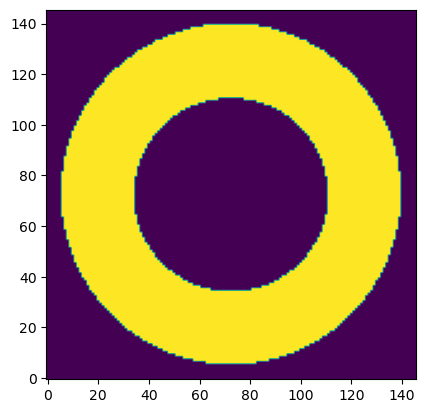

In [56]:
plt.imshow(template, origin='lower')

So if we convolve an in-focus image with a donut template it doesn't really work:

In [70]:
# Find the centroid by finding the max point in an initial
# cutout convolved with a template

correlatedImage = correlate(initialCutout.image.array, template)
maxIdx = np.argmax(correlatedImage)
maxLoc = np.unravel_index(maxIdx, np.shape(correlatedImage))
#plt.imshow(correlatedImage)

Text(0.5, 1.0, 'correlated')

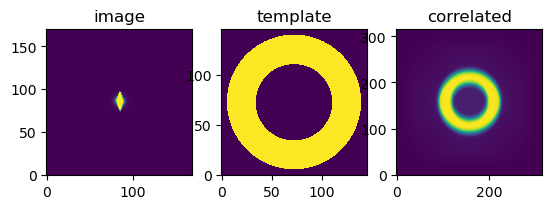

In [66]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(initialCutout.image.array, origin='lower')
ax[0].set_title('image')
ax[1].imshow(template, origin='lower')
ax[1].set_title('template')
ax[2].imshow(correlatedImage, origin='lower')
ax[2].set_title('correlated')

Try using a PSF template:



Text(0.5, 1.0, 'correlated')

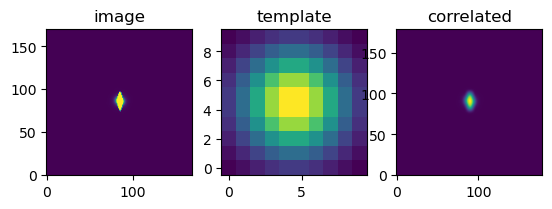

In [112]:
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage

def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
#NOTE should look at which centroid is run to see if there are better ones
psf_array = gkern(l=10, sig=2.5)
# #psf_array = gkern(l=5, sig=0.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
#psf_kernel = lsst.afw.math.FixedKernel(psf_image)
#psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

template = psf_array#  psf_image.array

correlatedImage = correlate(initialCutout.image.array, template)
maxIdx = np.argmax(correlatedImage)
maxLoc = np.unravel_index(maxIdx, np.shape(correlatedImage))

fig,ax = plt.subplots(1,3)
ax[0].imshow(initialCutout.image.array, origin='lower')
ax[0].set_title('image')
ax[1].imshow(template, origin='lower')
ax[1].set_title('template')
ax[2].imshow(correlatedImage, origin='lower')
ax[2].set_title('correlated')

In [113]:
psf_array

array([[0.00109137, 0.00206976, 0.00334489, 0.00460634, 0.00540558,
        0.00540558, 0.00460634, 0.00334489, 0.00206976, 0.00109137],
       [0.00206976, 0.00392526, 0.00634351, 0.00873583, 0.01025159,
        0.01025159, 0.00873583, 0.00634351, 0.00392526, 0.00206976],
       [0.00334489, 0.00634351, 0.01025159, 0.01411775, 0.01656733,
        0.01656733, 0.01411775, 0.01025159, 0.00634351, 0.00334489],
       [0.00460634, 0.00873583, 0.01411775, 0.01944194, 0.02281533,
        0.02281533, 0.01944194, 0.01411775, 0.00873583, 0.00460634],
       [0.00540558, 0.01025159, 0.01656733, 0.02281533, 0.02677404,
        0.02677404, 0.02281533, 0.01656733, 0.01025159, 0.00540558],
       [0.00540558, 0.01025159, 0.01656733, 0.02281533, 0.02677404,
        0.02677404, 0.02281533, 0.01656733, 0.01025159, 0.00540558],
       [0.00460634, 0.00873583, 0.01411775, 0.01944194, 0.02281533,
        0.02281533, 0.01944194, 0.01411775, 0.00873583, 0.00460634],
       [0.00334489, 0.00634351, 0.0102515

In [97]:
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
#NOTE should look at which centroid is run to see if there are better ones
psf_array = gkern(l=100, sig=3.5)
np.shape(psf_array)

(100, 100)

In [93]:
psf_array

array([[6.74510648e-39, 3.46459527e-38, 1.72170747e-37, ...,
        1.72170747e-37, 3.46459527e-38, 6.74510648e-39],
       [3.46459527e-38, 1.77957463e-37, 8.84347721e-37, ...,
        8.84347721e-37, 1.77957463e-37, 3.46459527e-38],
       [1.72170747e-37, 8.84347721e-37, 4.39470691e-36, ...,
        4.39470691e-36, 8.84347721e-37, 1.72170747e-37],
       ...,
       [1.72170747e-37, 8.84347721e-37, 4.39470691e-36, ...,
        4.39470691e-36, 8.84347721e-37, 1.72170747e-37],
       [3.46459527e-38, 1.77957463e-37, 8.84347721e-37, ...,
        8.84347721e-37, 1.77957463e-37, 3.46459527e-38],
       [6.74510648e-39, 3.46459527e-38, 1.72170747e-37, ...,
        1.72170747e-37, 3.46459527e-38, 6.74510648e-39]])

In [ ]:
Ok that makes much more sense.  So we could use that template instead. 

In [76]:

# The actual donut location is at the center of the template
# But the peak of correlation will correspond to the [0, 0]
# corner of the template
templateHalfWidth = int(len(template) / 2)
newX = maxLoc[1] - templateHalfWidth
newY = maxLoc[0] - templateHalfWidth
finalDonutX = xCent + (newX - initialHalfWidth)
finalDonutY = yCent + (newY - initialHalfWidth)

# Shift stamp center if necessary but not final centroid definition
xStampCent = shiftCenter(finalDonutX, expDim.getX(), stampHalfWidth)
xStampCent = shiftCenter(xStampCent, 0, stampHalfWidth)
yStampCent = shiftCenter(finalDonutY, expDim.getY(), stampHalfWidth)
yStampCent = shiftCenter(yStampCent, 0, stampHalfWidth)

# Define corner for final stamp BBox
xCorner = xStampCent - stampHalfWidth
yCorner = yStampCent - stampHalfWidth


#### END OF  calculateFinalCentroid



In [83]:
xShift = finalDonutX - xCent
yShift = finalDonutY - yCent
# If shift is greater than maxRecenteringDistance
# then use no shift at all
recenterDist = np.sqrt(xShift**2.0 + yShift**2.0)
recenterFlag = 0

#finalXCentList.append(finalDonutX)
#finalYCentList.append(finalDonutY)
#recenterFlags.append(recenterFlag)

# Get the final cutout
finalCorner = lsst.geom.Point2I(xCorner, yCorner)
finalBBox = lsst.geom.Box2I(
    finalCorner, lsst.geom.Extent2I(donutStampSize)
)
#xCornerList.append(xCorner)
#yCornerList.append(yCorner)
finalCutout = exposure[finalBBox].clone()

# Save MaskedImage to stamp
finalStamp = finalCutout.getMaskedImage()

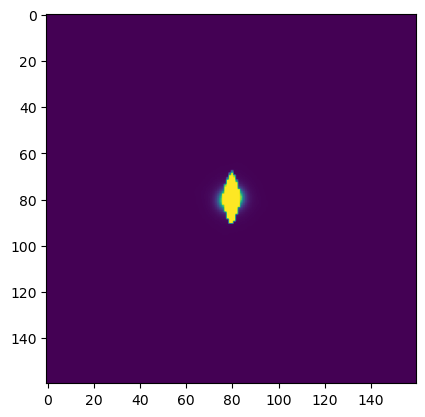

In [84]:
plt.imshow(finalStamp.image.array)

ok, so it is centered.  So a small modification - use a template that's a 2D PSF,  and otherwise can just use the same.  

This would be the call to `cutOutDonutsBase` 


    self.cutOutStamps(
            exposures,
            sourceCatalog,
            DefocalType.Focus,
            cameraName,
        )

In [ ]:

# Stamp BBox defined by corner pixel and extent
xCorner = xCent - initialHalfWidth
yCorner = yCent - initialHalfWidth

# Just use the `centroid` location for cutout 


finalCorner = lsst.geom.Point2I(xCorner, yCorner)
finalBBox = lsst.geom.Box2I(
finalCorner, lsst.geom.Extent2I(donutStampSize)
)

finalCutout = exposure_focus[finalBBox].clone()

# Save MaskedImage to stamp
finalStamp = finalCutout.getMaskedImage()


cutoutStamps.append(finalStamp)

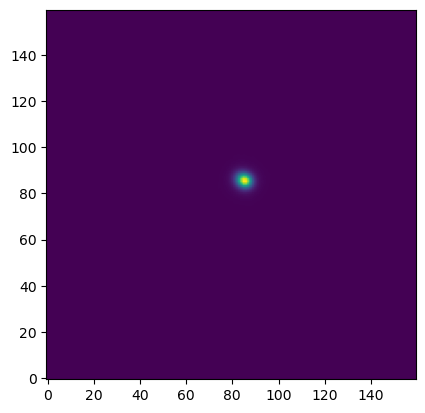

In [49]:
plt.imshow(cutoutStamps[6].image.array, origin='lower')

Introduce re-centroiding, just like in `cutOutDonuts`. Or even use the same one. 

# All-in-one : developing  cutOutStars. Run generateDonutDirectDetect,  then cutOutStarsScienceSensorTask

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:

from lsst.ts.wep.task.cutOutStarsScienceSensorTask import (
    CutOutStarsScienceSensorTask,
    CutOutStarsScienceSensorTaskConfig,
)

from lsst.daf import butler as dafButler
from copy import copy
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTaskConfig,
GenerateDonutDirectDetectTask)


path_cwd = '/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo_1e9')

collection = 'run1'
instrument= 'LSSTComCam'
detector=1
exposure_number = 5025082000942

# construct a dataId  for postISR extra-focal 
data_id_focus = { "detector": detector, "instrument": instrument, "exposure": exposure_number-1}

# read the postISR exposure

butler = dafButler.Butler(butlerRootPath)
exposure_focus = butler.get("postISRCCD", data_id_focus, collections=[collection])

camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections=["LSSTComCam/calib/unbounded",],
)


# Run source detection
config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.doPreConvolution = False


taskDirect = GenerateDonutDirectDetectTask(config=config)
catDirect = taskDirect.run(copy(exposure_focus), camera)

srcCat = catDirect.donutCatalog

# Run star cutouts 
config = CutOutStarsScienceSensorTaskConfig()
task = CutOutStarsScienceSensorTask(config=config, name="Cutout Stars ")


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 390 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 390 of 390 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 10/390 references


In [3]:
taskout = task.run(exposure_focus, srcCat, camera) 

task.run?

In [4]:
taskout.starStamps

## So now this could be run as a pipetask... Try doing that:

#!/bin/bash -l 

REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
INPUT_COLLECTION=run1
OUTPUT_COLLECTION=starStamps_focus
PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/stars_pipeline.yaml
    
  cat <<EOF > $PIPELINE_FILE
  description: Stars pipeline
  instrument: lsst.obs.lsst.LsstComCam
  tasks:
    generateDonutDirectDetectTask:
      class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
      config:
        donutSelector.sourceLimit: 5
        measurementTask.doPreConvolution : False
    cutOutStarsScienceSensorTask: lsst.ts.wep.task.cutOutStarsScienceSensorTask.CutOutStarsScienceSensorTask
EOF
    
pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "exposure.day_obs=20250820 and visit.seq_num in (941) and instrument='LSSTComCam'" --register-dataset-types



I'm trying to debug by first running donut catalogs, then cutouts separately

In [ ]:
Try `remove-dataset-types` : 


butler remove-dataset-type cutOutStarsScienceSensorTask_metadata

# Putting a new plotAOSTask with in-focus image 

In [ ]:
I re-cut stamps to make them smaller:


    #!/bin/bash -l 
    
    REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
    INPUT_COLLECTION=LSSTComCam/calib/unbounded,run1
    OUTPUT_COLLECTION=starCatalogs_941
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/starsPipelineCatalogOnly.yaml
        
      cat <<EOF > $PIPELINE_FILE
      description: Stars pipeline
      instrument: lsst.obs.lsst.LsstComCam
      tasks:
        generateDonutDirectDetectTask:
          class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
          config:
            donutSelector.sourceLimit: 5
            measurementTask.doPreConvolution : False
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "exposure.day_obs=20250820 and exposure.seq_num=941 and instrument='LSST
    ComCam'" --register-dataset-types


via  `source starsPipeline.sh `

and then cut them out: 

    #!/bin/bash -l 
    
    REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
    INPUT_COLLECTION=LSSTComCam/calib/unbounded,starCatalogs_941
    OUTPUT_COLLECTION=starCutout_941_test_80
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/starsPipelineCutoutOnly.yaml
        
      cat <<EOF > $PIPELINE_FILE
      description: Stars pipeline
      instrument: lsst.obs.lsst.LsstComCam
      tasks:
        cutOutStarsScienceSensorTask: 
            class: lsst.ts.wep.task.cutOutStarsScienceSensorTask.CutOutStarsScienceSensorTask
            config.donutStampSize: 80
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "exposure.day_obs=20250820 and exposure.seq_num=941 and instrument='LSST
    ComCam'" --register-dataset-types


via `source starsPipelineCutout.sh `

And 

`source starPipelineAgg.sh`  
    starCutout_941_test_80   ->  starCutout_941_test_agg_80



In [ ]:
Currently,  the task is run as 

    REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
    INPUT_COLLECTION=donutViz_940-942_direct_test2
    OUTPUT_COLLECTION=donutViz_940-942_agg
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/donut_pipeline_agg.yaml
        
     cat <<EOF > $PIPELINE_FILE
     description: Donut pipeline
     instrument: lsst.obs.lsst.LsstComCam
     tasks:
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: 
        class: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "exposure.day_obs=20250820 and visit.seq_num in (940,942) and instrument
    ='LSSTComCam'" --register-dataset-types

In [ ]:
because it needed to run `aggregateZernikesTask`  ,  `aggregateDonutCatalogsTask` ,  `aggregateAOSVisitTable`...   

before `plotAOSTask` and finally `plotDonutTask`  


Need to add `starStamps` aggregation to `aggregateVisit.py`   , and `plotStarsTask` to `plotAOSTask.py`.





Aggregation:

In [6]:
collection='starCutout_941_test'
datasetRefs = butler.registry.queryDatasets(datasetType='starStamps',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)


starStamps@{instrument: 'LSSTComCam', detector: 0, visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test/20240809T203502Z id=7896319e-fab4-44e4-9b19-d75c290624ef)
starStamps@{instrument: 'LSSTComCam', detector: 1, visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test/20240809T203502Z id=4e0aab24-a4cd-4810-9cfc-001ae35b20ae)
starStamps@{instrument: 'LSSTComCam', detector: 2, visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test/20240809T203502Z id=b67b3496-6778-4a1f-911e-79b4e08302b0)
starStamps@{instrument: 'LSSTComCam', detector: 3, visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test/20240809T203502Z id=d94b4922-2dad-44a7-b14d-c9fe31d328ff)
starStamps@{instrument: 'LSSTComCam', detector: 4, visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test/20240809T203502Z i

Try running the aggregation:

The pipeline:

    #!/bin/bash -l 
    
    REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
    INPUT_COLLECTION=starCutout_941_test
    OUTPUT_COLLECTION=starCutout_941_test_agg
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/starPipeline_agg.yaml
        
     cat <<EOF > $PIPELINE_FILE
     description: Star pipeline
     instrument: lsst.obs.lsst.LsstComCam
     tasks:
      aggregateStarStampsTask: lsst.donut.viz.AggregateStarStampsTask
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "visit.day_obs=20250820 and visit.seq_num=941 and instrument='LSSTComCam
    '" --register-dataset-types

The setup:

    setup -k -r /home/s/scichris/link_to_scichris/WORK/donut_viz
    cd /sdf/group/rubin/shared/scichris/DM-41679_lsstComCam/


    source starPipelineAgg.sh

I get this dataset:

In [44]:
butler = dafButler.Butler(butlerRootPath)
collection = 'starCutout_941_test_agg_80' 
#butler.registry.queryDatasetTypes()#collection=[collection])

In [45]:
datasetRefs = butler.registry.queryDatasets(datasetType='starStampsVisit',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)

starStampsVisit@{instrument: 'LSSTComCam', visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test_agg_80/20240809T215909Z id=dc3fcd2e-a600-43e1-ac80-d68459e9ec61)


Ok this aggregated all starStamps  per visit into a single ref. If I read this ref that would be only one donut per detector:

In [46]:
ref.dataId.visit

visit.RecordClass(instrument='LSSTComCam', id=5025082000941, physical_filter='g_01', name='IM_P_20250820_000941', day_obs=20250820, seq_num=941, exposure_time=15.0, target_name='UNKNOWN', observation_reason='survey', science_program='68661', azimuth=None, zenith_angle=None, region=ConvexPolygon([UnitVector3d(0.059721775597359396, -0.13090458486377476, -0.9895945125055724), UnitVector3d(0.06376964052795439, -0.12909745299017475, -0.9895793452666568), UnitVector3d(0.06882471780083474, -0.1404355415081154, -0.9876947994704426), UnitVector3d(0.06508420753249194, -0.1421058038907733, -0.9877094645848163), UnitVector3d(0.057292473539824536, -0.14557585567565104, -0.9876868140863229), UnitVector3d(0.05399495196070508, -0.13818011312631134, -0.9889341745026111), UnitVector3d(0.05223739634545768, -0.13423776695632936, -0.9895713599057047)]), timespan=Timespan(begin=astropy.time.Time('2025-08-20 05:56:31.670602', scale='tai', format='iso'), end=astropy.time.Time('2025-08-20 05:56:46.671000', scale='tai', format='iso')))

In [47]:
datasetRefs = butler.registry.queryDatasets(datasetType='starStampsVisit',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)
starStamps = butler.get('starStampsVisit', collections=[collection], dataId = ref.dataId)

## [Aside: counting saturated pixels in the mask]

In [151]:
all_idx = np.arange(10)

In [153]:
bad_idx = np.array([0,1,5])

In [164]:
bad_idx = [4,5]

In [161]:
bad_idx = []

In [165]:
good_idx = [idx for idx in all_idx if idx not in bad_idx]

In [166]:
good_idx

[0, 1, 2, 3, 6, 7, 8, 9]

In [ ]:
def countPixels(maskedImage, maskPlane):
    """Count the number of pixels in an image with a given mask bit set.

    Parameters
    ----------
    maskedImage : `lsst.afw.image.MaskedImage`
        The masked image,
    maskPlane : `str`
        The name of the bitmask.

    Returns
    -------
    count : `int``
        The number of pixels in with the selected mask bit
    """
    bit = maskedImage.mask.getPlaneBitMask(maskPlane)
    return len(np.where(np.bitwise_and(maskedImage.mask.array, bit))[0])

There should be 9 star stamps:

In [62]:
np.unique(exposure_focus.mask.array)

array([0, 2], dtype=int32)

In [89]:
out=  exposure_focus.mask.getMaskPlane('SAT')

In [114]:
exposure_focus.mask??

Type:        property
String form: <property object at 0x7f6f1456e7f0>
Source:     
# exposure_focus.mask.fget
def getMask(self):
    return self.maskedImage.mask

# exposure_focus.mask.fset
def setMask(self, mask):
    self.maskedImage.mask = mask

In [115]:
np.unique(exposure_focus.mask.array)

array([0, 2], dtype=int32)

In [123]:
exposure_focus.mask.getPlaneBitMask("BAD")

1

In [121]:
(exposure_focus.mask.array & exposure_focus.mask.getPlaneBitMask("BAD")) == 0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [116]:
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.geom as geom
import lsst.pipe.base as pipeBase

bbox = geom.Box2I(geom.Point2I(3,4), geom.Extent2I(300, 200))
exp = afwImage.ExposureF(bbox)
maskedImage = exp.getMaskedImage()
maskedImage.variance.array[...] += 3.
maskedImage.mask.array[...] = 0

clipIter = 2
sigmaClip = 3.0
calcErrorFromInputVariance = True
maskPropagationThresholds = {"SAT": 0.1}
statistic = "MEANCLIP"

mask = afwImage.Mask.getPlaneBitMask(("NO_DATA", "BAD", "SAT", "EDGE"))
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setNumSigmaClip(sigmaClip)
statsCtrl.setNumIter(clipIter)
statsCtrl.setAndMask(mask)
statsCtrl.setNanSafe(True)
statsCtrl.setWeighted(True)
statsCtrl.setCalcErrorFromInputVariance(calcErrorFromInputVariance)
for plane, threshold in maskPropagationThresholds.items():
    bit = afwImage.Mask.getMaskPlane(plane)
    statsCtrl.setMaskPropagationThreshold(bit, threshold)

statObj = afwMath.makeStatistics(maskedImage.getVariance(), maskedImage.getMask(),
                                 afwMath.MEANCLIP, statsCtrl)

lsst.afw.image._image.MaskX=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}

In [128]:
bit = exposure_focus.mask.getPlaneBitMask(('SAT','BAD', 'NO_DATA'))
#bit = exposure_focus.mask.getPlaneBitMask(( 'NO_DATA'))
 
len(np.where(np.bitwise_and(exposure_focus.mask.array, bit))[0])


2652

In [99]:
mask_sat = np.where(np.bitwise_and(exposure_focus.mask.array, bit))


array([164053.36, 164294.47, 164331.27, ..., 164320.28, 160350.31,
       161588.06], dtype=float32)

2652

In [101]:
#plt.imshow(exposure_focus.image.array[mask_sat])

https://lsstc.slack.com/archives/C2K97E3L5/p1645564826553449?thread_ts=1645559393.678019&cid=C2K97E3L5 


    thresh = afwDetection.Threshold(mask.getPlaneBitMask(maskNameList), afwDetection.Threshold.BITMASK)


The relevant question https://lsstc.slack.com/archives/C2K97E3L5/p1645556277920429 


This gets the relevant bit: 


    bit = maskedImage.mask.getPlaneBitMask('CR')





In [94]:
exposure_focus.mask.getPlaneBitMask(maskPlane)

NameError: name 'maskPlane' is not defined

In [80]:
# maskedImage.mask.getPlaneBitMask(maskPlane) to get the bit-value, and then use np.bitwise_and() with it.

<function lsst.afw.image._image.PyCapsule.getMaskPlane>

## Read aggregated star stamps

In [177]:
butler = dafButler.Butler(butlerRootPath)
collection = 'starCutout_941_test_agg_80_noSta' 
datasetRefs = butler.registry.queryDatasets(datasetType='starStampsVisit',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)
starStamps = butler.get('starStampsVisit', collections=[collection], dataId = ref.dataId)

starStampsVisit@{instrument: 'LSSTComCam', visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test_agg_80_noSta/20240810T004424Z id=6c18ef7c-45f2-4735-ac11-710759c5ca0b)
starStampsVisit@{instrument: 'LSSTComCam', visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test_agg_80_noSta/20240810T004556Z id=9c267af1-8e07-437d-b85d-bb06e474543c)


In [227]:
butler = dafButler.Butler(butlerRootPath)
collection = 'starCutout_941_test_agg_80_noSta' 
#datasetRefs = butler.registry.queryDatasets(datasetType='starStampsVisit',collections=[collection]).expanded()

In [228]:
butler.registry.queryDatasetTypes()

[DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('packages', {}, Packages),
 DatasetType('isr_config', {}, Config),
 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, TaskMetadata),
 DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog),
 DatasetType('cutOutDonutsScienceSensorTask_config', {}, Config),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('generateDonutCatalogWcsTask_config', {}, Config),
 DatasetType('donutCatalog', {band, instrument, detector, physical_filter, visit}, DataFrame),
 DatasetType('donutStampsExtra', {band, instrument, detector, physical_filter, visit}, StampsBase),
 DatasetType('donutStampsIntra', {

In [169]:
len(starStamps)

9

And indeed there are! So now we can plot one per sensor: 

In [170]:
collection = 'run1'
instrument= 'LSSTComCam'
detector=1
exposure_number = 5025082000942
data_id_focus = { "detector": detector, "instrument": instrument, "exposure": exposure_number-1}
exposure_focus = butler.get("postISRCCD", data_id_focus, collections=[collection])

In [171]:
visitInfo = exposure_focus.getInfo().getVisitInfo()

In [172]:
visitInfo.boresightParAngle

Angle(57.539379342295753, degrees)

In [173]:
import numpy as np 
# LSST detector layout
q = visitInfo.boresightParAngle.asRadians()
rotAngle = visitInfo.boresightRotAngle.asRadians()
rtp = q - rotAngle - np.pi/2
match inst:=visitInfo.getInstrumentLabel():
    case 'LSSTCam' | 'LSSTCamSim':
        nacross = 15
        fp_size = 0.55  # 55% of horizontal space
    case 'LSSTComCam' | 'LSSTComCamSim':
        nacross = 3
        fp_size = 0.50  # 50% of horizontal space
    case _:
        raise ValueError(f"Unknown instrument {inst}")
det_size = fp_size/nacross
fp_center = 0.5, 0.475


In [174]:
sys.path.append('/home/s/scichris/link_to_scichris/WORK/donut_viz/python/lsst/donut/viz')
from utilities import (
    rose, add_rotated_axis, get_instrument_channel_name,
    get_day_obs_seq_num_from_visitid
)

In [175]:
visit = visitInfo.id
visit

5025082000941

Text(0.47, 0.93, 'focus: 5025082000941')

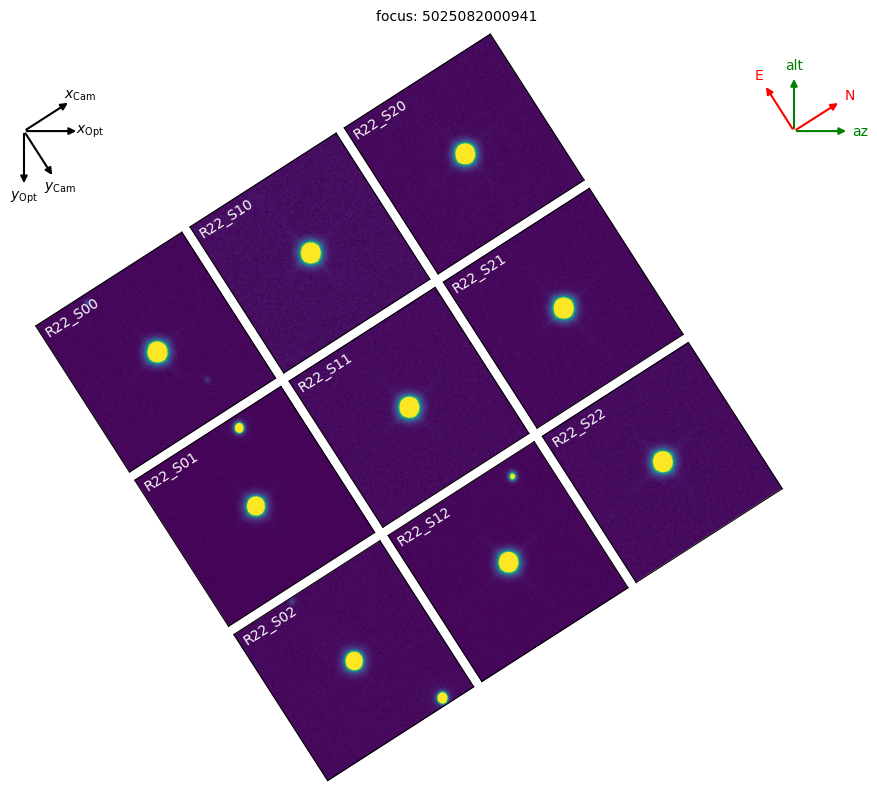

In [178]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11, 8.5))
aspect = fig.get_size_inches()[0] / fig.get_size_inches()[1]
for stamp in starStamps:
    det_name = stamp.detector_name
    # if 'R30' in det_name:
    #     continue
    # if 'S00' in det_name:
    #     continue
    # if 'S01' in det_name:
    #     continue
    i = 3*int(det_name[1]) + int(det_name[5])
    j = 3*int(det_name[2]) + int(det_name[6])
    x = i-7
    y = 7-j
    xp = np.cos(rtp)*x + np.sin(rtp)*y
    yp = -np.sin(rtp)*x + np.cos(rtp)*y
    ax, aux_ax = add_rotated_axis(
        fig,
        (xp*det_size + fp_center[0], yp*det_size*aspect + fp_center[1]),
        (det_size*1.25, det_size*1.25),
        -np.rad2deg(rtp)
    )
    arr = stamp.stamp_im.image.array
    vmin, vmax = np.quantile(arr, (0.01, 0.99))
    aux_ax.imshow(
        stamp.stamp_im.image.array.T,
        vmin=vmin, vmax=vmax,
        extent=[0, det_size*1.25, 0, det_size*1.25],
        origin='upper'  # +y is down
    )
    xlim = aux_ax.get_xlim()
    ylim = aux_ax.get_ylim()
    aux_ax.text(
        xlim[0] + 0.03 * (xlim[1] - xlim[0]),
        ylim[1] - 0.03 * (ylim[1] - ylim[0]),
        det_name,
        color='w',
        rotation=-np.rad2deg(rtp),
        rotation_mode='anchor',
        ha='left',
        va='top'
    )

vecs_xy = {
    '$x_\mathrm{Opt}$':(1,0),
    '$y_\mathrm{Opt}$':(0,-1),
    '$x_\mathrm{Cam}$':(np.cos(rtp), -np.sin(rtp)),
    '$y_\mathrm{Cam}$':(-np.sin(rtp), -np.cos(rtp)),
}
rose(fig, vecs_xy, p0=(0.15, 0.8))

vecs_NE = {
    'az':(1,0),
    'alt':(0,+1),
    'N':(np.sin(q), np.cos(q)),
    'E':(np.sin(q-np.pi/2), np.cos(q-np.pi/2))
}
rose(fig, vecs_NE, p0=(0.85, 0.8))
fig.text(0.47, 0.93, f'{stamp.defocal_type}: {visit}')

In [222]:
psf = exposure_focus.getPsf()

In [224]:
psf

Test the pipetask run to make an image. We already know that the aggregation step works, so try:


    #!/bin/bash -l 
    
    REPO=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/gen3repo_1e9
    INPUT_COLLECTION=starCutout_941_test_80
    OUTPUT_COLLECTION=starCutout_941_test_plot
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41679_lsstComCam/starPipeline_agg.yaml
        
     cat <<EOF > $PIPELINE_FILE
     description: Star pipeline
     instrument: lsst.obs.lsst.LsstComCam
     tasks:
      aggregateStarStampsTask: lsst.donut.viz.AggregateStarStampsTask
      plotStarTask: lsst.donut.viz.PlotStarTask
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "visit.day_obs=20250820 and visit.seq_num=941 and instrument='LSSTComCam'" --register-dataset-types



setup -k -r /home/s/scichris/link_to_scichris/WORK/donut_viz
cd /sdf/group/rubin/shared/scichris/DM-41679_lsstComCam/
    
source starPipelineAggToPlot.sh 


I get 


        lsst.pipe.base.pipeline_graph._exceptions.IncompatibleDatasetTypeError: Incompatible definition for input dataset type 'starStamps'; task 'plotStarTask' has DatasetType('starStamps', {band, instrument, physical_filter, visit}, StampsBase), but the definition from data repository is DatasetType('starStamps', {band, instrument, detector, physical_filter, visit}, StampsBase).


Try removing the datasetType...  ? But there are datasets associated with that (eg. starStamps cutout).  

No - instead I needed to make sure that the `dimensions` for `plotStarTaskConnections.starStamps` are the same as those of stamps being made... 


    class PlotStarTaskConnections(
        pipeBase.PipelineTaskConnections,
        dimensions=("visit", "instrument"),
    ):
    
    .....
    
      starStamps = ct.Input(
            doc="In-focus Star Stamps",
            dimensions=("visit", "detector", "instrument"),
            storageClass="StampsBase",
            name="starStamps",
        )

    

Test if there is any output:

In [229]:
butler = dafButler.Butler(butlerRootPath)
collection = 'starCutout_941_test_plot' 
datasetRefs = butler.registry.queryDatasets(datasetType='starStampsVisit',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)

starStampsVisit@{instrument: 'LSSTComCam', visit: 5025082000941, band: 'g', physical_filter: 'g_01'} [sc=StampsBase] (run=starCutout_941_test_plot/20240813T000310Z id=c6828083-6195-4be7-b831-fa4a4fdefbc3)


In [231]:
ref.dataId['visit']

5025082000941

ok, the plot isn't made as `VisitInfo` is missing... 

In [ ]:
In `plotAOSTask.py`  `VisitInfo` is made 

In [ ]:
Where are ` inputRefs.visitInfos:` ?  How can I make one ? 

** Test files for in-focus ** 

butler ingest-raws -t relsymlink gen3TestRepo phosimOutput/realComCam/repackagedFiles/extra/*.fits
butler ingest-raws -t relsymlink gen3TestRepo phosimOutput/realComCam/repackagedFiles/intra/*.fits
butler define-visits gen3TestRepo lsst.obs.lsst.LsstCam


Use only one in-focus exposure from DM-41679_lsstComCam:

https://lsstc.slack.com/archives/C01FBUGM2CV/p1709322816111629

      butler register-instrument . lsst.obs.lsst.LsstComCam --update


visit 68661   has the seqNums 940,941, 942 

    $TARGET = /home/s/scichris/link_to_scichris/WORK/aos_packages/ts_wep/tests/testData/imsimOutput/lsstComCam
    $SOURCE =  /sdf/group/rubin/shared/scichris/DM-41679_lsstComCam/output-max-flux-1e9/00068661/amp_00068661-0-g-R22_S00-det000-0.0.fits.fz
    cp $TARGET $SOURCE
    butler ingest-raws . ../imsimOutput/lsstComCam/amp*
    butler define-visits . lsst.obs.lsst.LsstComCam

cmd = f"butler define-visits {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"


- use a more realistic PSF as a correlation template? 


# test_cutOutStarsScienceSensorTask

In [181]:
from lsst.ts.wep.utils import (
DefocalType,
getModulePath,
runProgram,
writeCleanUpRepoCmd,
writePipetaskCmd,
)
moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections()) 

In [182]:
collectionsList

['LSSTCam/raw/all',
 'refcats/gen2',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTComCam/calib',
 'LSSTComCam/calib/unbounded',
 'refcats/largeCatSingleCCD',
 'LSSTComCam/raw/all']

In [183]:
collection = 'LSSTComCam/raw/all' 
datasetRefs = butler.registry.queryDatasets(datasetType='raw',collections=[collection]).expanded()
pipeRefs = []
for ref  in datasetRefs:
    print(ref)
    pipeRefs.append(ref)

raw@{instrument: 'LSSTComCam', detector: 0, exposure: 5025082000941, band: 'g', day_obs: 20250820, group: '5025082000941', physical_filter: 'g_01'} [sc=Exposure] (run=LSSTComCam/raw/all id=e63a51d7-f12f-5d39-b761-10070b1198cd)


In [186]:
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
# Point to the collections for the reference catalogs,
# the raw images and the camera model in the calib directory
# that comes from `butler write-curated-calibrations`.
runName = "run1"

collections = "LSSTComCam/calib,LSSTComCam/raw/all"
instrument = "lsst.obs.lsst.LsstComCam"
cameraName = "LSSTComCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testCutoutsStarsPipeline.yaml "
)

pipeCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
pipeCmd += " -d 'exposure=5025082000941'"
runProgram(pipeCmd)


py.warnings WARNING: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,

py.warnings WARNING: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,

lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 3 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 3 quanta, 16 dataset nodes, and 13 edges from 1 query row(s).
lsst.pipe.base.

Ok, this runs ISR, direct detection, and cutouts . At a minimum, add `testTaskRun` : 

In [187]:
config = CutOutStarsScienceSensorTaskConfig()


In [208]:
config.donutStampSize = 60

In [209]:
task = CutOutStarsScienceSensorTask(config=config)

In [189]:
butler = dafButler.Butler(repoDir)

In [190]:
dataIdFocus = {
            "instrument": "LSSTComCam",
            "detector": 0,
            "exposure": 5025082000941,
            "visit": 5025082000941,
        }

In [192]:
exposureFocus = butler.get(
    "postISRCCD", dataId=dataIdFocus, collections=[runName]
)

sourceCatalog = butler.get(
    "donutCatalog", dataId=dataIdFocus, collections=[runName]
)

camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections="LSSTComCam/calib/unbounded",
)

In [194]:
import pandas as pd
noSrcDonutCatalog = pd.DataFrame(columns=sourceCatalog.columns)
testOutNoSrc = task.run(exposureFocus, noSrcDonutCatalog, camera
)


In [195]:
testOutNoSrc

Struct(starStamps=<lsst.ts.wep.task.donutStamps.DonutStamps object at 0x7f6ef329dc50>)

In [210]:
taskOut = task.run(exposureFocus,sourceCatalog,camera)


In [213]:
import lsst.utils.tests

In [214]:
test = lsst.utils.tests.TestCase()

In [215]:
test.assertMaskedImagesAlmostEqual?

Signature:
test.assertMaskedImagesAlmostEqual(
    maskedImage0,
    maskedImage1,
    doImage=True,
    doMask=True,
    doVariance=True,
    skipMask=None,
    rtol=1e-05,
    atol=1e-08,
    msg='Masked images differ',
)
Docstring:
!Assert that two masked images are nearly equal, including non-finite values

@param[in] testCase  unittest.TestCase instance the test is part of;
                    an object supporting one method: fail(self, msgStr)
@param[in] maskedImage0  masked image 0 (an lsst.afw.image.MaskedImage or
    collection of three transposed numpy arrays: image, mask, variance)
@param[in] maskedImage1  masked image 1 (an lsst.afw.image.MaskedImage or
    collection of three transposed numpy arrays: image, mask, variance)
@param[in] doImage  compare image planes if True
@param[in] doMask  compare mask planes if True
@param[in] doVariance  compare variance planes if True
@param[in] skipMask  mask of pixels to skip, or None to compare all pixels;
    an lsst.afw.image.Mask,

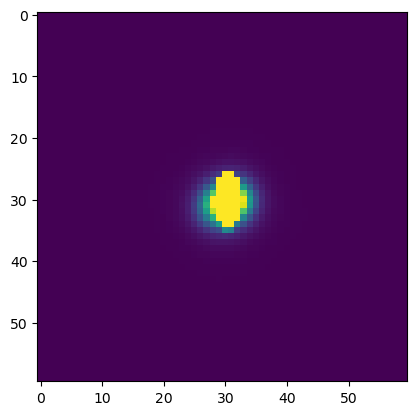

In [212]:
plt.imshow(taskOut.starStamps[0].stamp_im.image.array)

In [199]:
len(taskOut.starStamps)

10

In [200]:
testStamps = task.cutOutStamps(
            exposureFocus, sourceCatalog, DefocalType.Focus, camera.getName()
        )

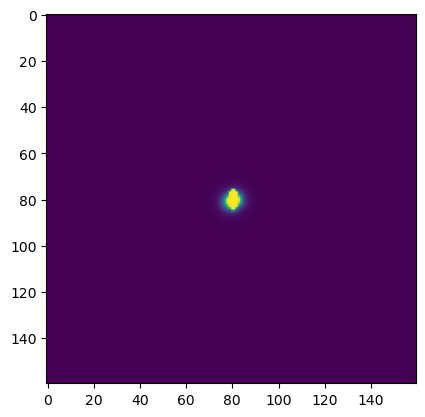

In [206]:
plt.imshow(testStamps[0].stamp_im.image.array)

In [202]:
len(testStamps)

10

But without re-centroiding,  we're not necessarily centered... I wonder what else may be needed ... 

Left : extra ,  Middle  : in-focus,   Right : intra    (and so on for more defocal positions...)

How would it work for larger donuts?  Would we be able to adjust the template? Can we even use that to cutout larger donuts?  

## Use DM-41944_comcam_sweep_stamp

Previously we've simulated LsstComCam  focus sweep with 5 positions: 

In [6]:
from lsst.daf import butler as dafButler
import numpy as np

butlerRootPath = '/sdf/data/rubin/shared/scichris/DM-41944_comcam_sweep_stamp/gen3repo'
butlerInstName = 'ComCam'
butler = dafButler.Butler(butlerRootPath)

runName = 'run1'

day_obs = 280818

exposures = {}
seq_num = 940 
offsets_mm = 1e-3*  np.linspace(-1.5,1.5,5 )  # to be in mm 
for focusz_mm in  offsets_mm :
    exp_id = int(f'50{day_obs}00{seq_num}')
    print( seq_num,  focusz_mm, exp_id)
    exposures[focusz_mm] = butler.get('postISRCCD', 
                                      dataId={'instrument':f'LSST{butlerInstName}', 
                                              'detector':'R22_S11', 
                                              'exposure':exp_id}, 
                                      collections=[runName]
                                     )

    seq_num += 1 
    

940 -0.0015 5028081800940
941 -0.00075 5028081800941
942 0.0 5028081800942
943 0.00075 5028081800943
944 0.0015 5028081800944


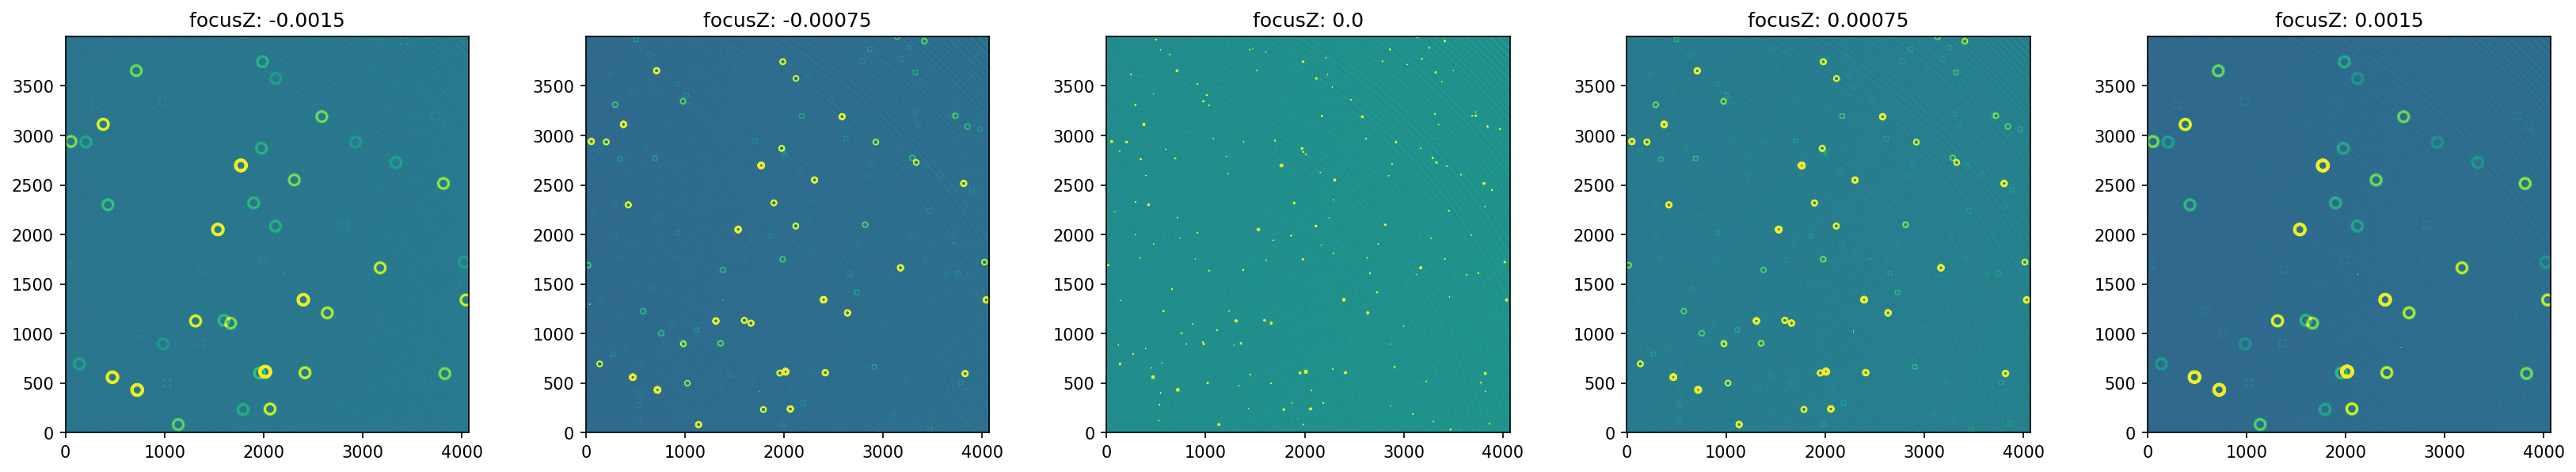

In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
fig,ax = plt.subplots(1,5, figsize=(27,5), dpi=150)
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41944_comcam_sweep_stamp/'
zscale = ZScaleInterval()
i=0
for focusz_mm in exposures.keys():
    exposure = exposures[focusz_mm]
    d = exposure.image.array
    focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].set_title(f'focusZ: {focusz_mm}')
    i += 1 
#fig.suptitle( f'detector: {exposure.detector.getId()} ({exposure.detector.getName()})')
#plt.colorbar(mappable, ax=ax[1]) 
fig.subplots_adjust(wspace=0.29)
plt.savefig(os.path.join(path_cwd, 'comcam_focus_sweep.png'), bbox_inches='tight')

-1.5


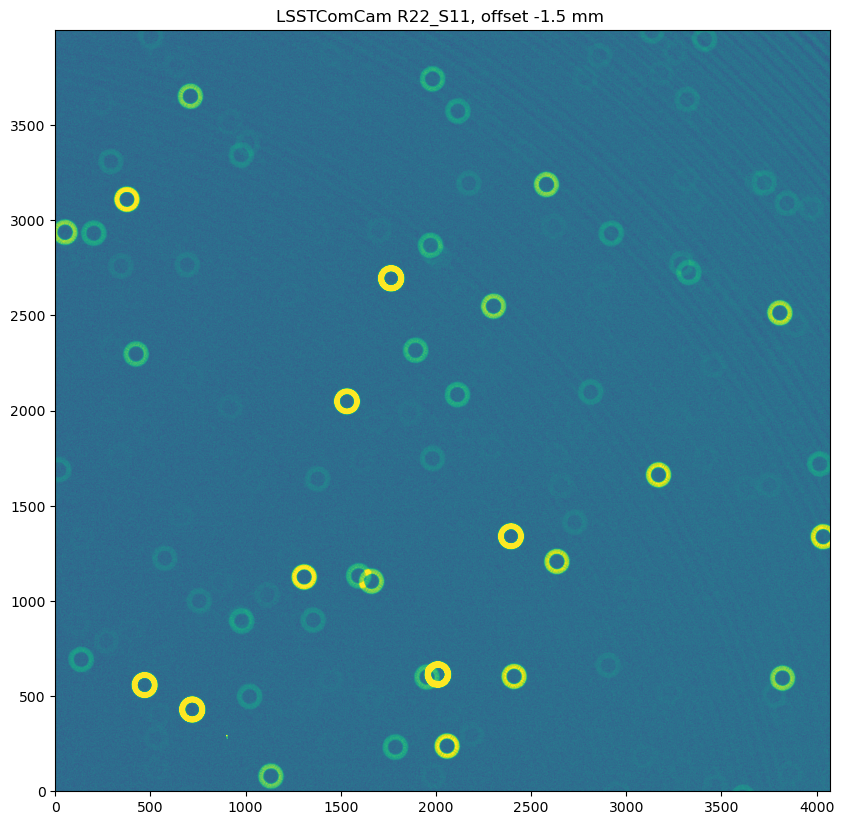

In [5]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
fig,ax = plt.subplots(1,1,figsize=(10,10))
exposure = exposures[-0.0015]
d = exposure.image.array
focusz = exposure.visitInfo.focusZ
vmin,vmax = zscale.get_limits(d)
mappable = ax.imshow(d, vmin=vmin, vmax=vmax, origin='lower')
ax.set_title(f'{exposure.visitInfo.instrumentLabel} {exposure.detector.getName()}, offset {focusz} mm ', )
print(focusz)

ok, looks just fine!  So we already have a dataset for the illustration... 

So test if `generateDonutDirectDetect` works - when do we need to stop pre-convolution ? 

In [7]:
from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig

from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import  ( 
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig)

from copy import copy 

config = GenerateDonutDirectDetectTaskConfig()

camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections=["LSSTComCam/calib/unbounded",],
)

donutCatalogs = {}

for focusz_mm in exposures.keys():
    exposure_mm = exposures[focusz_mm]
    exposure = copy(exposure_mm) # crucial step!!!! 
    taskDirect = GenerateDonutDirectDetectTask(config=config)
    catDirect = taskDirect.run(exposure, camera)
    donutCatalog = catDirect.donutCatalog
    donutCatalogs[focusz_mm] = donutCatalog

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 35 of 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/35 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 27 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 27 of 27 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/27 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 38 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 38 of 38 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/38 references
INFO:lsst.generateDonutDirectDetectTa

In [10]:
#for focusz_mm in exposures.keys():
#    print(donutCatalogs[focusz_mm])
    

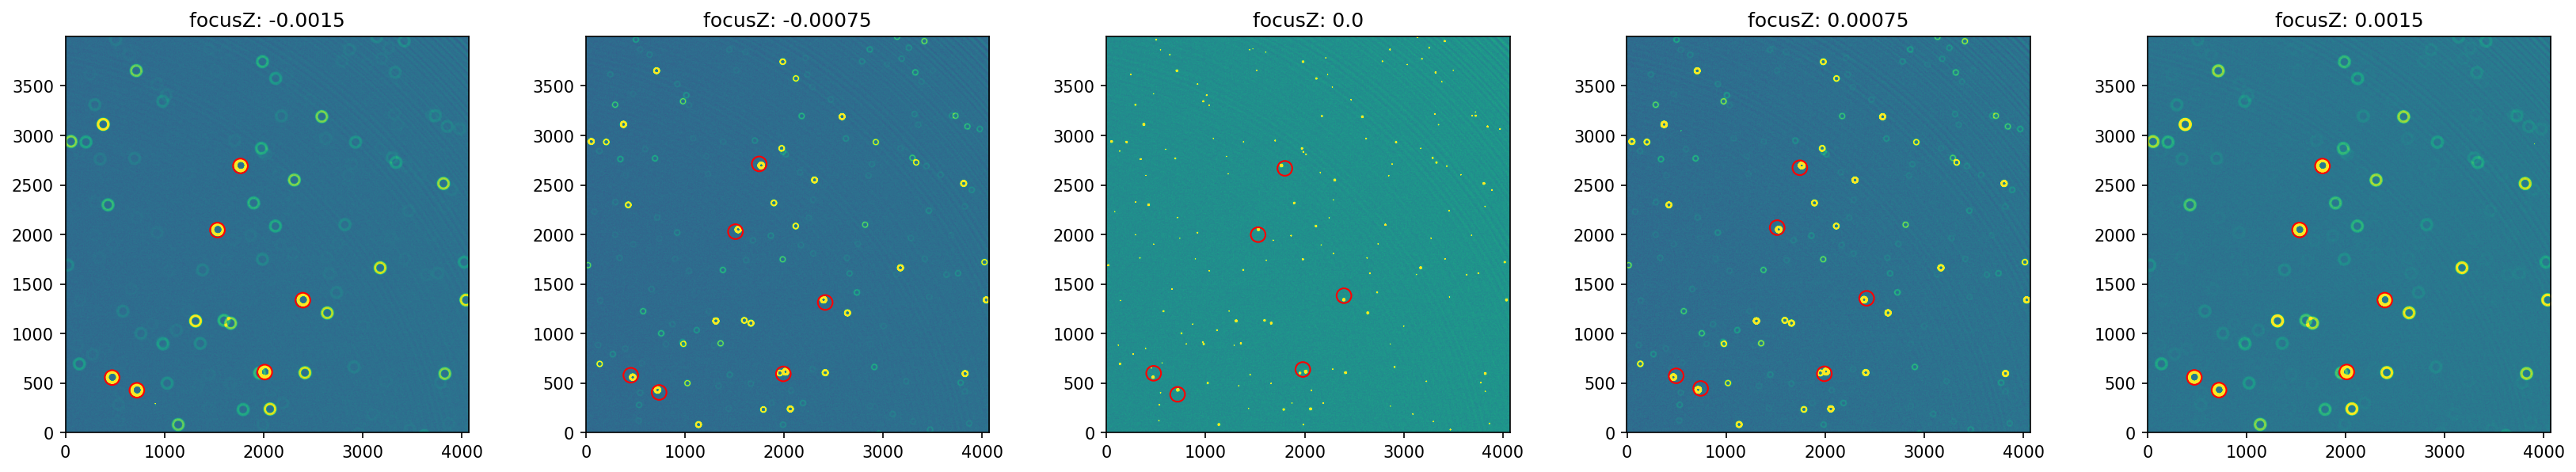

In [12]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
fig,ax = plt.subplots(1,5, figsize=(27,5), dpi=150)
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41944_comcam_sweep_stamp/'
zscale = ZScaleInterval()
i=0
for focusz_mm in exposures.keys():
    exposure = exposures[focusz_mm]
    d = exposure.image.array
    focusz = exposure.visitInfo.focusZ
    vmin,vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')

    srcCat =  donutCatalogs[focusz_mm] 
    ax[i].scatter( srcCat['centroid_x'], srcCat['centroid_y'],s=80, facecolors='none', edgecolors='r')
    
    ax[i].set_title(f'focusZ: {focusz_mm}')
    i += 1 
#fig.suptitle( f'detector: {exposure.detector.getId()} ({exposure.detector.getName()})')
#plt.colorbar(mappable, ax=ax[1]) 
fig.subplots_adjust(wspace=0.29)
plt.savefig(os.path.join(path_cwd, 'comcam_focus_sweep.png'), bbox_inches='tight')

In [13]:
import matplotlib.pyplot as plt

Try running just quickMeasurement on the in-focus image to cutout stamps... 

Input:  exposure  

Process: QuickMeasurement task 

Output:  Stamp cutouts around point sources 


